In [1]:
import sys
sys.path.append('tismir-beat-2024/')

import numpy as np
from scipy.stats import gmean
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt

import librosa
from essentia.standard import Crest

# https://github.com/maia-ls/tismir-beat-2024
from rhythmic_features.feature import compute_scale_transform_magnitudes

[   INFO   ] MusicExtractorSVM: no classifier models were configured by default


In [2]:
# Directory containing original field recordings
ORIG_DIR = '../crem_bell'

# Directory containing Demucs-separated (non-voice) tracks
DEMUCS_DIR = '../separated/htdemucs'

In [3]:
def crest(comps):
    """Compute crest array from NMF templates
    
    Args:
        comps (np.ndarray): NMF components (N x D)
        
    Returns:
        crest (np.ndarray): Crest of each spectral component (1 x D)
    """
    crst = []
    for i in range(comps.shape[1]):
        crst.append(Crest()(comps[:,i]))
    return np.array(crst)

def activation_onset_strength_reconstructed(comps, acts, S, freqs, n_fft=512, hop_length=160, lag=3,
                                            detrend=True, func=np.mean, C=1000):
    """Compute onset strength from reconstructed signal with selected activations
    
    Args:
        comps (np.ndarray): NMF components (N x D)
        acts (np.ndarray): NMF activations (D x M)
        S (np.ndarray): Original spectrogram (F x M)
        freqs (np.ndarray): FFT frequencies (F x 1)
        n_fft (int): Number of FFT points
        hop_length (int): Hop size
        lag (int): Lag for computing onset strength
        detrend (bool): Makes the spectral flux locally zero-meaned (Default value = True)
        func (function): Function for crest-based selection
        C (scalar): Log-compression for computing onset strength
    """
    
    # Selecting components based on crest factor
    crst = crest(comps)
    if isinstance(func, int):
        idx = crst > np.partition(crest(comps), func)[func]
    elif func == 'all':
        idx = np.array([True] * len(crest(comps)))
    else:
        idx = crst >= func(crst)
    
    # Reconstructing spectrogram with selected components
    Ss = np.zeros(S.shape)
    Ss[(freqs >= fmin) & (freqs <= fmax), :] = comps[:,idx].dot(acts[idx,:])
    ys = librosa.istft(Ss * np.exp(1j * np.angle(S)), n_fft=n_fft, hop_length=hop_length)

    # Computing onset strength
    oss = librosa.onset.onset_strength(S=np.log(1+C*Ss), sr=sr/hop_length, lag=lag, detrend=detrend)
    return oss, ys

def normalize_minmax(x):
    """Min-max normalization
    
    Args:
        x (nd.array): Data"""
    return (x - x.min()) / (x.max() - x.min())

In [4]:
# Parameters
# Resampling frequency
sr = 8000

# STFT
n_fft = 512
hop_length = 160
fmin = 650
fmax = 4000
freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)

# NMF
n_components = 6
max_iter = 1200

# Onset strength
detrend = True
sigma = 1

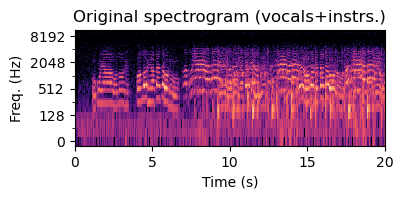

In [5]:
filename = 'CNRSMH_I_2007_011_004_03' 
x, fs = librosa.load(f'{ORIG_DIR}/{filename}.wav', sr=None, duration=60)

S = librosa.stft(y=x, n_fft=n_fft, hop_length=hop_length)

fig, ax = plt.subplots(figsize=(4,1.5))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(S), ref=np.max),
                         hop_length=hop_length,
                         y_axis='log', x_axis='time', ax=ax, sr=fs)
ax.set_xlim(0, 20)
ax.set_yticks([0, 128, 512, 2048, 8192], minor=False)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Freq. (Hz)')
ax.set_title('Original spectrogram (vocals+instrs.)');

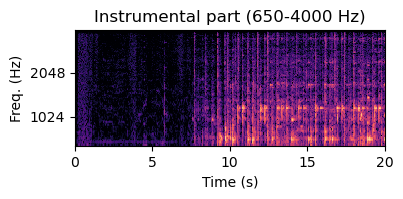

In [6]:
x, fs = librosa.load(f'{DEMUCS_DIR}/{filename}/no_vocals.wav', sr=None, duration=60)
x = librosa.resample(y=x, orig_sr=fs, target_sr=sr)

S = librosa.stft(y=x, n_fft=n_fft, hop_length=hop_length)
freqs_idx = (freqs >= fmin) & (freqs <= fmax)
Sn = S[freqs_idx, :].copy()

fig, ax = plt.subplots(figsize=(4,1.5))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(Sn), ref=np.max),
                         hop_length=hop_length, y_coords=freqs[freqs_idx],
                         y_axis='log', x_axis='time', ax=ax, sr=sr)
ax.set_xlim(0, 20)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Freq. (Hz)')
ax.set_title('Instrumental part (650-4000 Hz)');

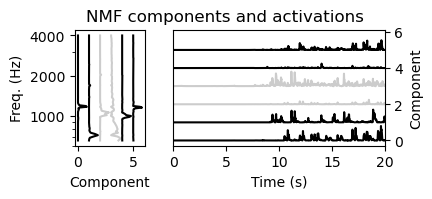

In [7]:
comps, acts = librosa.decompose.decompose(np.abs(Sn), n_components=n_components, max_iter=max_iter)

fig, ax = plt.subplots(1,2,figsize=(4,1.5), gridspec_kw={'width_ratios': (1,3)})

ev = crest(comps) > gmean(crest(comps))
for i in range(len(ev)):
    c = 'k' if ev[i] else 'k'
    a = 1 if ev[i] else .2
    ax[0].semilogy(.8*normalize_minmax(comps[:,i]) + i, freqs[freqs_idx], c=c, alpha=a)
    ax[1].plot(librosa.times_like(acts[i,:], sr=sr, hop_length=hop_length), .8*normalize_minmax(acts[i,:]) + i, c=c, alpha=a)

from matplotlib.ticker import ScalarFormatter, NullFormatter
ax[0].yaxis.set_major_formatter(ScalarFormatter())
ax[0].yaxis.set_minor_formatter(NullFormatter())
    
ax[0].set_ylabel('Freq. (Hz)')
ax[0].set_xlabel('Component')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Component')
ax[0].set_yticks([1000, 2000, 4000])
ax[1].set_xlim(0, 20)
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
plt.suptitle('NMF components and activations', y=1.02);

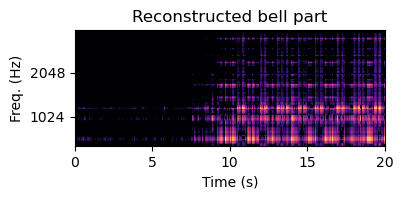

In [8]:
Ss = np.zeros(Sn.shape)
Ss = comps[:,ev].dot(acts[ev,:])

fig, ax = plt.subplots(figsize=(4,1.5))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(Ss), ref=np.max),
                         hop_length=hop_length, y_coords=freqs[freqs_idx],
                         y_axis='log', x_axis='time', ax=ax, sr=sr)
ax.set_xlim(0, 20)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Freq. (Hz)')
ax.set_title('Reconstructed bell part');

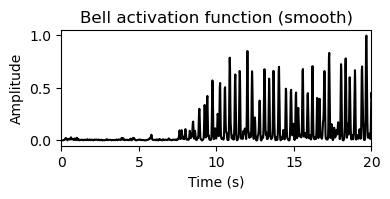

In [9]:
o, _ = activation_onset_strength_reconstructed(comps, acts, S, freqs, lag=3, detrend=False, func=gmean)
o = gaussian_filter1d(o, sigma)

fig, ax = plt.subplots(figsize=(4,1.5))
ax.plot(librosa.times_like(o, hop_length=hop_length, sr=sr), normalize_minmax(o), c='k');
ax.set_xlim(0, 20)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude')
ax.set_title('Bell activation function (smooth)');

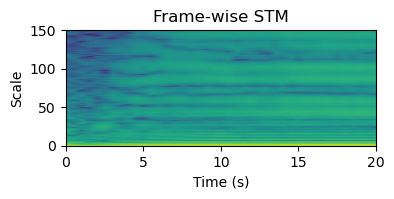

In [10]:
Rm, _, _, R, _, _ = compute_scale_transform_magnitudes(o=o, sr=sr/hop_length, scale_transform='direct')

fig, ax = plt.subplots(figsize=(4,1.5))
librosa.display.specshow(librosa.amplitude_to_db(R, ref=np.max),
                         hop_length=int(np.ceil(.5*sr/hop_length)), sr=sr/hop_length,
                         y_axis='linear', x_axis='time', ax=ax, y_coords=np.arange(R.shape[0]),
                         shading='gouraud', cmap='viridis')
ax.set_xlim(0, 20)
ax.set_ylim(0, 150)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Scale')
ax.set_title('Frame-wise STM');